Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/automated-machine-learning/regression/auto-ml-regression.png)

# Automated Machine Learning
_**Regression with Aml Compute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)



## Introduction
In this example we use the Hardware Performance Dataset to showcase how you can use AutoML for a simple regression problem. The Regression goal is to predict the performance of certain combinations of hardware parts.

If you are using an Azure Machine Learning Compute Instance, you are all set.  Otherwise, go through the [configuration](../../../configuration.ipynb)  notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Test the best fitted model.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
 

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [2]:
print("This notebook was created using version 1.14.0 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.14.0 of the Azure ML SDK
You are currently using version 1.14.0 of the Azure ML SDK


In [3]:
ws = Workspace.from_config()

# Choose a name for the experiment.
experiment_name = 'automl-regression'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,80b2bae0-9f97-4190-a0d1-f57c078442d8
Workspace,autolmwa
Resource Group,automl
Location,westus
Run History Name,automl-regression


### Using AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you use `AmlCompute` as your training compute resource.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "reg-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Data


### Load Data
Load the hardware dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model. 

In [28]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/machineData.csv"
dataset = Dataset.Tabular.from_delimited_files(data)

# Split the dataset into train and test datasets
train_data, test_data = dataset.random_split(percentage=0.8, seed=223)

label = "ERP"


## Train

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification, regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|(sparse) array-like, shape = [n_samples, n_features]|
|**label_column_name**|(sparse) array-like, shape = [n_samples, ], targets values.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [6]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'r2_score',
    "enable_early_stopping": True, 
    "experiment_timeout_hours": 0.3, #for real scenarios we reccommend a timeout of at least one hour 
    "max_concurrent_iterations": 4,
    "max_cores_per_iteration": -1,
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'regression',
                             compute_target = compute_target,
                             training_data = train_data,
                             label_column_name = label,
                             **automl_settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Execution of remote runs is asynchronous. Depending on the data and the number of iterations this can run for a while.  Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [7]:
remote_run = experiment.submit(automl_config, show_output = False)

Running on remote or ADB.


In [8]:
# If you need to retrieve a run that already started, use the following code
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

In [9]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-regression,AutoML_5943dab3-cfd2-4e2f-9820-bdcf433f9e71,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [19]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [11]:
remote_run.wait_for_completion()

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [20]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-regression,
Id: AutoML_5943dab3-cfd2-4e2f-9820-bdcf433f9e71_21,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                            

#### Best Model Based on Any Other Metric
Show the run and the model that has the smallest `root_mean_squared_error` value (which turned out to be the same as the one with largest `spearman_correlation` value):

In [21]:
lookup_metric = "root_mean_squared_error"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automl-regression,
Id: AutoML_5943dab3-cfd2-4e2f-9820-bdcf433f9e71_21,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                            

#### Model from a Specific Iteration
Show the run and the model from the third iteration:

In [22]:
iteration = 3
third_run, third_model = remote_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automl-regression,
Id: AutoML_5943dab3-cfd2-4e2f-9820-bdcf433f9e71_3,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                             

## Test

In [29]:
# preview the first 3 rows of the dataset

test_data = test_data.to_pandas_dataframe()
y_test = test_data['ERP'].fillna(0)
test_data = test_data.drop('ERP', 1)
test_data = test_data.fillna(0)


train_data = train_data.to_pandas_dataframe()
y_train = train_data['ERP'].fillna(0)
train_data = train_data.drop('ERP', 1)
train_data = train_data.fillna(0)


In [30]:
y_pred_train = fitted_model.predict(train_data)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(test_data)
y_residual_test = y_test - y_pred_test

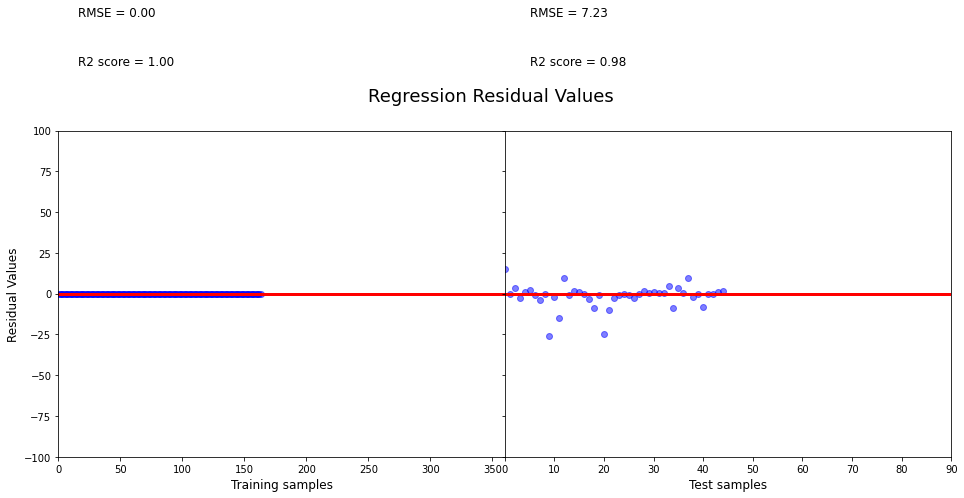

In [31]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -100, 100])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)),fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot residual values of test set.
a1.axis([0, 90, -100, 100])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)),fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

plt.show()

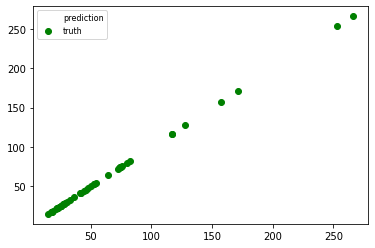

In [26]:
%matplotlib inline
test_pred = plt.scatter(y_test, y_pred_test, color='')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()